In [2]:
import sys
import os


sys.path.append(os.path.abspath("/Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation"))
from imports import *

In [20]:
file_path = '../Features/rabbit_corrvar.xlsx'
df = pd.read_excel(file_path)
df.head()

,Irritation,MaxAbsEStateIndex,MinAbsEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,AvgIpc,...,fr_ketone_Topliss,fr_methoxy,fr_nitro,fr_nitro_arom_nonortho,fr_para_hydroxylation,fr_pyridine,fr_sulfide,fr_sulfonamd,fr_unbrch_alkane,fr_urea
0,1,0.380977,0.301948,0.403803,0.385193,0.187251,0.199575,0.550820,0.588235,0.452681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.277350,0.0
1,1,0.443959,0.118847,0.725612,0.470253,0.326442,0.202175,0.550534,0.560784,0.542612,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,1,0.049599,0.376730,0.440935,0.382546,0.249141,0.032276,0.304644,0.633987,0.404010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.160128,0.0
3,1,0.297132,0.200094,0.634828,0.454915,0.257268,0.120148,0.629576,0.650624,0.467685,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,1,0.067411,0.305414,0.501957,0.647698,0.225299,0.075490,0.315990,0.835294,0.471625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [21]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation'])  # Assuming 'Call' is the target variable
y = df['Irritation']

In [135]:

# First, split data into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=5)


# Print dataset sizes
print(f"Train set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")


Train set: 1424 samples
Test set: 356 samples


In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [136]:
def objective(trial):
    # Define hyperparameter search space
    param = {
        "n_neighbors": trial.suggest_int("n_neighbors", 10, 15),  
        "p": trial.suggest_int("p", 1, 2),
    }
    
    # Set up cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    valid_scores = []

    for train_idx, valid_idx in kf.split(X_train, y_train):
        X_train_cv, X_valid_cv = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_cv, y_valid_cv = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        model = KNeighborsClassifier(**param) 
        model.fit(X_train_cv, y_train_cv)
 
        valid_acc = accuracy_score(y_valid_cv, model.predict(X_valid_cv))
        valid_scores.append(valid_acc)

    return np.mean(valid_scores)

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print best hyperparameters
print("Best trial:", study.best_trial.params)

# Train final model with best parameters
best_params = study.best_trial.params
final_model = KNeighborsClassifier(**best_params)
final_model.fit(X_train, y_train)

# Evaluate on test set
y_pred_final = final_model.predict(X_test)
print("Final Model Accuracy:", accuracy_score(y_test, y_pred_final))


[I 2025-03-30 17:32:12,763] A new study created in memory with name: no-name-9ff68250-6cad-4923-8323-01f0d98217c7
[I 2025-03-30 17:32:12,861] Trial 0 finished with value: 0.8300494193229554 and parameters: {'n_neighbors': 11, 'p': 1}. Best is trial 0 with value: 0.8300494193229554.
[I 2025-03-30 17:32:12,908] Trial 1 finished with value: 0.8244279713367927 and parameters: {'n_neighbors': 13, 'p': 2}. Best is trial 0 with value: 0.8300494193229554.
[I 2025-03-30 17:32:12,954] Trial 2 finished with value: 0.8335656041512232 and parameters: {'n_neighbors': 11, 'p': 2}. Best is trial 2 with value: 0.8335656041512232.
[I 2025-03-30 17:32:13,004] Trial 3 finished with value: 0.8335656041512232 and parameters: {'n_neighbors': 11, 'p': 2}. Best is trial 2 with value: 0.8335656041512232.
[I 2025-03-30 17:32:13,054] Trial 4 finished with value: 0.8188238201136645 and parameters: {'n_neighbors': 15, 'p': 2}. Best is trial 2 with value: 0.8335656041512232.
[I 2025-03-30 17:32:13,129] Trial 5 finis

Best trial: {'n_neighbors': 14, 'p': 1}
Final Model Accuracy: 0.8539325842696629


In [137]:

# First, split data into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)


# Print dataset sizes
print(f"Train set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Get best hyperparameters from study
best_params = {'n_neighbors': 11, 'p': 1}

# Initialize the KNN model with best parameters
final_model = KNeighborsClassifier(**best_params)

# Fit the model on the training data
final_model.fit(X_train, y_train)

test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Train set: 1424 samples
Test set: 356 samples
Train Accuracy: 0.8679775280898876
Test Accuracy: 0.8426966292134831


In [138]:
test_accuracies = []
train_accuracies = []

for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    
    best_params = study.best_trial.params

    final_model = KNeighborsClassifier(**best_params)


    final_model.fit(X_train, y_train)


    test_accuracy = final_model.score(X_test, y_test)
    train_accuracy = final_model.score(X_train, y_train)
    #print("Train Accuracy:", train_accuracy)
    #print("Test Accuracy:", test_accuracy)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

print(np.mean(train_accuracies), np.mean(test_accuracies))

0.8617275280898877 0.8382022471910112


Final Model Accuracy on Test: 0.8792134831460674


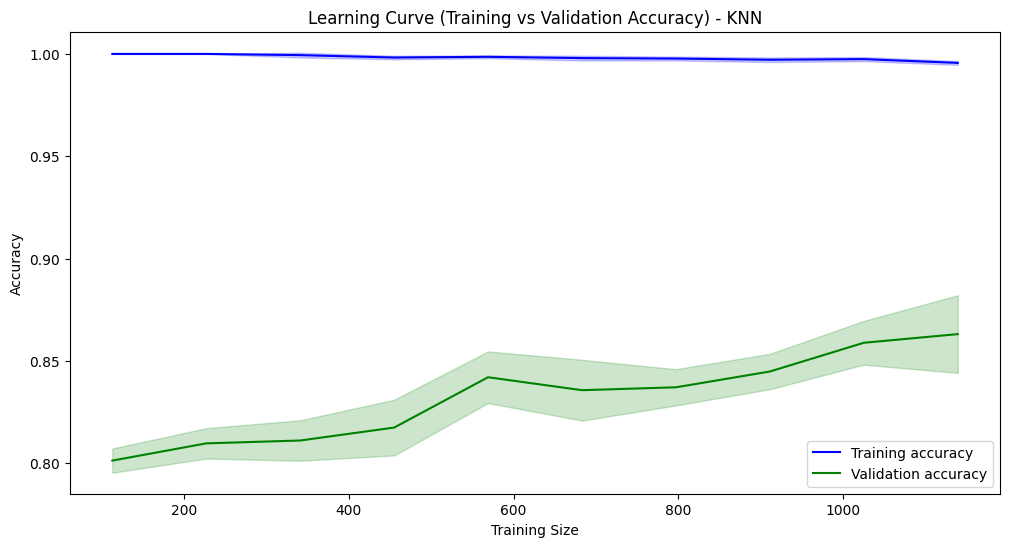

Train Accuracy: 0.9943820224719101
Test Accuracy: 0.8792134831460674


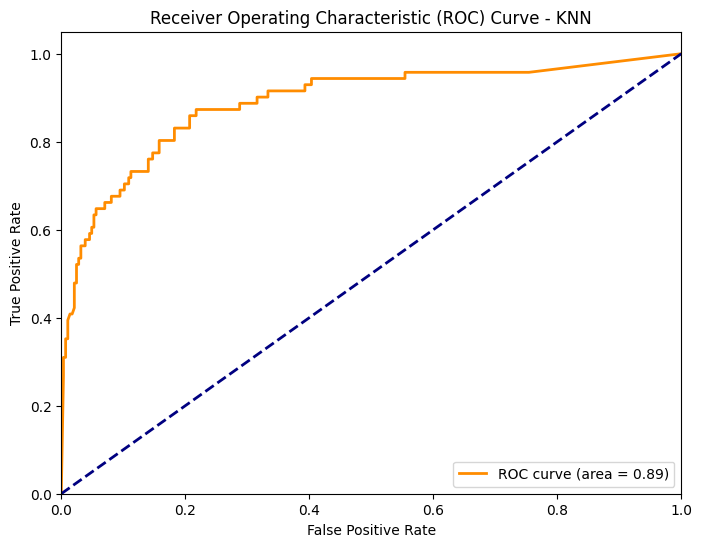

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import learning_curve
from matplotlib import pyplot as plt

# Get best hyperparameters from study
best_params = study.best_trial.params

# Initialize the KNN model with best parameters
final_model = KNeighborsClassifier(**best_params)

# Fit the model on the training data
final_model.fit(X_train, y_train)


# Learning Curves
train_sizes, train_scores, validation_scores = learning_curve(
    final_model, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label='Training accuracy', color='blue')
plt.plot(train_sizes, validation_mean, label='Validation accuracy', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.2)
plt.title('Learning Curve (Training vs Validation Accuracy) - KNN')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# ROC Curve
y_prob = final_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - KNN')
plt.legend(loc='lower right')
plt.show()


In [10]:

# First, split data into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)


# Print dataset sizes
print(f"Train set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")


Train set: 1424 samples
Test set: 356 samples


Best k based on test accuracy: 12
Best Training Accuracy: 0.8596
Best Testing Accuracy: 0.8539
Best k based on bias-variance tradeoff: 18


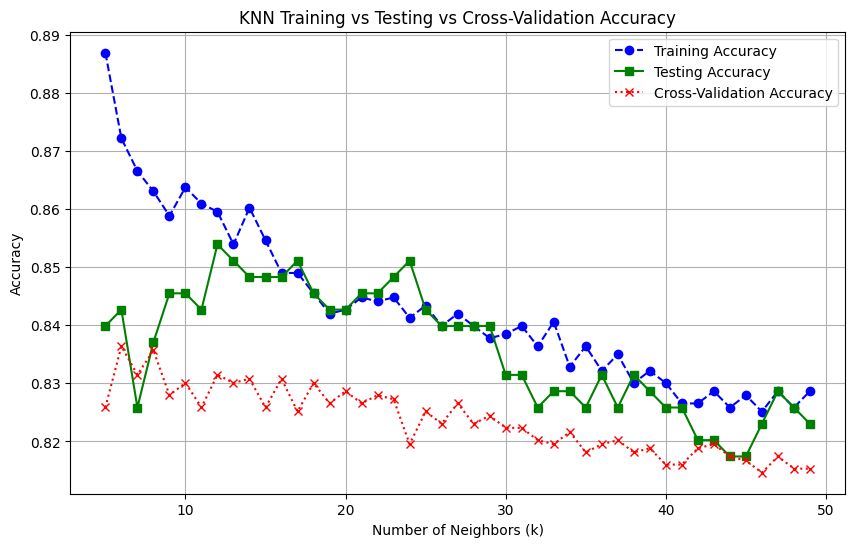

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Define range of k values
k_values = range(5, 50)
train_accuracies = []
test_accuracies = []
cv_accuracies = []

# Iterate over different k values
best_k = 1
best_test_acc = 0
best_train_acc = 0
best_tradeoff_k = 1
best_tradeoff_value = float('inf')

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)  # Train the model
    
    # Compute training and test accuracy
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    # Perform cross-validation (5-fold)
    cv_acc = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))
    
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    cv_accuracies.append(cv_acc)
    
    # Track best k based on test accuracy
    if test_acc > best_test_acc:
        best_k = k
        best_test_acc = test_acc
        best_train_acc = train_acc
    
    # Find the best tradeoff between bias and variance
    tradeoff_value = abs(train_acc - test_acc)
    if tradeoff_value < best_tradeoff_value:
        best_tradeoff_value = tradeoff_value
        best_tradeoff_k = k

# Print best k and corresponding accuracy
print(f"Best k based on test accuracy: {best_k}")
print(f"Best Training Accuracy: {best_train_acc:.4f}")
print(f"Best Testing Accuracy: {best_test_acc:.4f}")
print(f"Best k based on bias-variance tradeoff: {best_tradeoff_k}")

# Plot training vs testing vs cross-validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, label='Training Accuracy', marker='o', linestyle='dashed', color='blue')
plt.plot(k_values, test_accuracies, label='Testing Accuracy', marker='s', linestyle='solid', color='green')
plt.plot(k_values, cv_accuracies, label='Cross-Validation Accuracy', marker='x', linestyle='dotted', color='red')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Training vs Testing vs Cross-Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [28]:
# Reduce background samples for KernelExplainer (e.g., take 50 samples)
background_summary = shap.sample(X_train, 50)

# Initialize KernelExplainer
explainer = shap.KernelExplainer(final_model.predict_proba, background_summary)

# Reduce number of samples to explain (e.g., only 500 test samples)
X_sample = shap.sample(X_test, 500)

# Compute SHAP values with fewer samples (set nsamples lower for faster results)
shap_values = explainer.shap_values(X_sample, nsamples=100)

  0%|          | 0/498 [00:00<?, ?it/s]

/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 79 iterations, alpha=1.517e-04, previous alpha=1.204e-04, with an active set of 42 regressors.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 79 iterations, alpha=3.957e-05, previous alpha=3.644e-05, with an active set of 44 regressors.
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_least_angle.py:688: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=3.033e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being

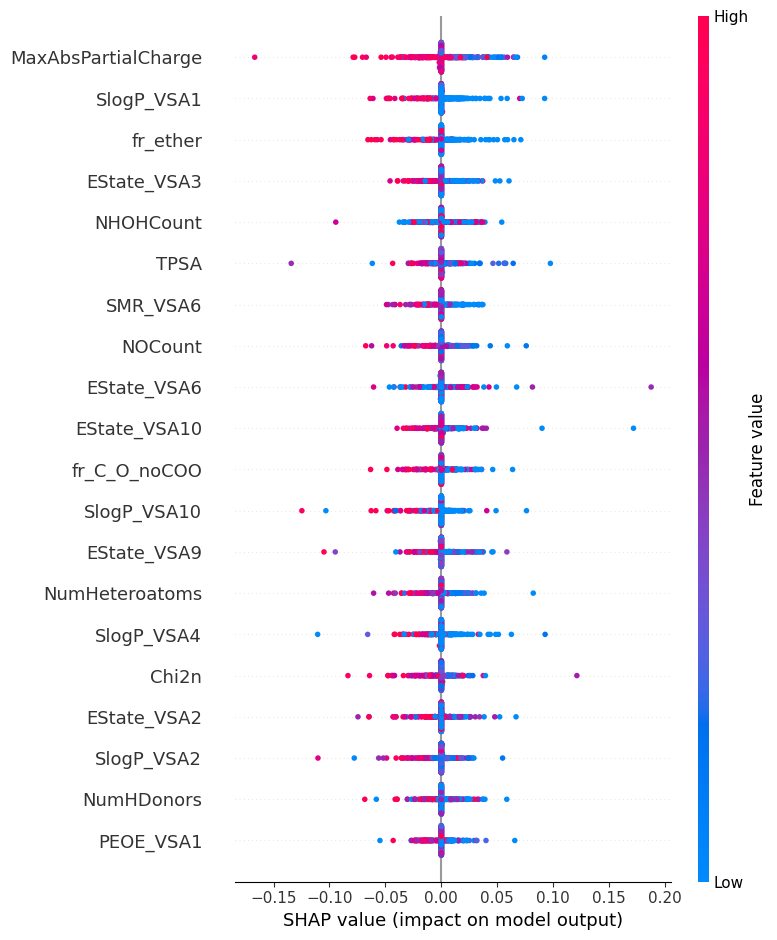

In [30]:
# Plot summary
shap.summary_plot(shap_values[:,:,1], X_sample)

In [139]:
import joblib

# Assuming 'model' is your trained QSAR model
joblib.dump(final_model, 'knn_model.pkl')

print("Model saved successfully!")


Model saved successfully!
